Installing and Importing Necessary Libraries

In [1]:
import torch
import numpy as np
import os
import json

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH = format_pytorch_version(torch.__version__)
CUDA = 'cu' + torch.version.cuda.replace('.', '')

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

In [ ]:
!pip install torch_geometric_temporal

Data Importing from Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Preprocessed Data Loading

In [4]:
def load_json(json_path):
  with open(json_path, 'r') as f:
    return json.load(f)

classes = load_json('/content/drive/MyDrive/Sign-Language-Translator/data/sentence_class_names.json')
num_classes = len(classes)
print("Number of classes:", num_classes)

Number of classes: 101


In [34]:
class_to_label = {class_name: i for i, class_name in enumerate(classes)}
label_to_class = {i: class_name for i, class_name in enumerate(classes)}

In [35]:
from torch.utils.data import Dataset, DataLoader

In [36]:
def load_saved_data(data_path, train=False):
  if not os.path.exists(data_path):
    return []

  data_type = 'train' if train else 'test'
  features, labels = torch.load(data_path)[data_type]
  return list(zip(features, labels))

In [37]:
data_path = '/content/drive/MyDrive/Sign-Language-Translator/data/preprocessed_video_sentence_data.pth'
# data = load_saved_data(data_path)
# data[0][0].shape, data[0][1]

In [61]:
from types import new_class
class HandGestureDataset(Dataset):
    def __init__(self, saved_data_path='', train=False):
        self.cache = dict(enumerate(load_saved_data(saved_data_path, train)))

    def __len__(self):
        return len(self.cache)

    def __getitem__(self, idx):
        cached_data = self.cache[idx]
        features, label = cached_data[0], class_to_label[cached_data[1]]
        features = features.to(dtype=torch.float32)

        return features, label

def video_collate_fn(batch):
  batch = list(filter(lambda x: x[0] is not None, batch))

  videos, labels = zip(*batch)
  max_size = max(video.shape[0] for video in videos)

  padded_videos = []
  for video in videos:
    pad_size = max_size - video.shape[0]
    pad_tensor = torch.zeros((pad_size, *video.shape[1:]))
    padded_videos.append(torch.cat([pad_tensor, video], dim=0))

  return torch.stack(padded_videos), torch.tensor(labels)

In [62]:
train_dataset = HandGestureDataset(saved_data_path=data_path, train=True)
test_dataset = HandGestureDataset(saved_data_path=data_path)

In [63]:
len(train_dataset), len(test_dataset)

(3978, 137)

In [64]:
train_dataset[6][0].shape, train_dataset[6][1]

(torch.Size([15, 67, 4]), 61)

In [65]:
# Create DataLoaders for the training and testing datasets
# Set num_workers to 0 to avoid CUDA re-initialization issues with multiprocessing
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=video_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=video_collate_fn)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 3978
Testing dataset size: 137


In [66]:
for x_batch, y_batch in train_dataloader:
  print("Features data shape:", x_batch.shape, "Label:", y_batch.shape)
  # break

Features data shape: torch.Size([32, 44, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([32, 41, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([32, 40, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([32, 48, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([32, 43, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([32, 35, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([32, 43, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([32, 40, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([32, 36, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([32, 44, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([32, 52, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([32, 41, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([32, 43, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([32, 48, 67, 4]) La

In [67]:
for x_batch, y_batch in test_dataloader:
  print("Features data shape:", x_batch.shape, "Label:", y_batch.shape)
  # break

Features data shape: torch.Size([32, 26, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([32, 36, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([32, 28, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([32, 30, 67, 4]) Label: torch.Size([32])
Features data shape: torch.Size([9, 38, 67, 4]) Label: torch.Size([9])


Model Building and Training

In [68]:
from torch import nn
# from torch_geometric_temporal.nn import STConv

In [71]:
# ----- Frame Encoder -----
class FrameEncoder(nn.Module):
    def __init__(self, in_frame_size, hidden_neurons, dropout_rates, frame_dim, frame_fc_dropout):
        """
        in_frame_size: features per node (e.g. x,y,z,conf → 4)
        hidden_neurons: list of hidden layer sizes [64, 128, ...]
        frame_dim: output embedding dimension for each frame
        dropout_rates: list of dropouts per layer (same length as hidden_neurons)
        frame_fc_dropout: dropout for the fully-connected layer
        """
        super().__init__()
        layers = []
        input_dim = in_frame_size

        if dropout_rates is None:
            dropout_rates = [0.0] * len(hidden_neurons)

        # Feature Projections per node
        for h, dr in zip(hidden_neurons, dropout_rates):
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dr))
            input_dim = h

        self.node_proj = nn.Sequential(*layers)

        # Frame fully-connected projection
        self.frame_fc = nn.Sequential(
            nn.Linear(input_dim, frame_dim),
            nn.ReLU(),
            nn.Dropout(frame_fc_dropout)  # global dropout
        )

    def forward(self, x):
        # x: (B, T, N*F) -> flatten nodes per frame
        x = x.reshape(x.shape[0], x.shape[1], -1)  # (B,T,N*F)

        x = self.node_proj(x)          # (B,T,H_last)
        x = self.frame_fc(x)           # (B,T,frame_dim)
        return x

# ----- Sequence Classifier -----
class SequenceClassifier(nn.Module):
    def __init__(self, in_frame_dim, temporal_size, num_temporal_layers, temporal_dropout, output_size,
                 class_hidden_neurons, class_dropout_rates, rnn_type="GRU", bidir=True):
        """
        in_frame_dim: per-frame embedding dimension
        temporal_size: hidden size of temporal encoder
        num_temporal_layers: how many GRU/LSTM layers
        temporal_dropout: dropout for the temporal encoder
        class_hidden_neurons: list of hidden layer sizes for the classifier
        class_droput_rates: list of dropouts per layer (same length as class_hidden_neurons)
        rnn_type: "GRU" | "LSTM" | "RNN" | "TRANSFORMER"
        """
        super().__init__()
        self.use_transformer = rnn_type == "TRANSFORMER"

        if rnn_type == "GRU":
            self.rnn = nn.GRU(in_frame_dim, temporal_size,
                              num_layers=num_temporal_layers,
                              bidirectional=bidir, batch_first=True,
                              dropout=temporal_dropout if num_temporal_layers > 1 else 0.0)

        elif rnn_type == "LSTM":
            self.rnn = nn.LSTM(in_frame_dim, temporal_size,
                               num_layers=num_temporal_layers,
                               bidirectional=bidir, batch_first=True,
                               dropout=temporal_dropout if num_temporal_layers > 1 else 0.0)

        elif rnn_type == "TRANSFORMER":
            self.rnn = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=in_frame_dim, nhead=8, dropout=temporal_dropout, batch_first=True),
                num_layers=num_temporal_layers
            )

        else:
            self.rnn = nn.RNN(in_frame_dim, temporal_size,
                              num_layers=num_temporal_layers,
                              bidirectional=bidir, batch_first=True,
                              dropout=temporal_dropout if num_temporal_layers > 1 else 0.0)

        fc_input_size = temporal_size if (self.use_transformer or not bidir) else 2 * temporal_size

        # temporal pooling + classifier
        self.temp_pool = nn.AdaptiveAvgPool2d((1, fc_input_size))  # (B, 1, fc_input)

        layers = []
        input_dim = fc_input_size

        for h, dr in zip(class_hidden_neurons, class_dropout_rates):
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dr))
            input_dim = h

        layers.append(nn.Linear(input_dim, output_size))

        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        # x: (B, T, D)
        if self.use_transformer:
            seq_out = self.rnn(x)                   # (B,T,2*H)
        else:
            seq_out, _ = self.rnn(x)                # (B,T,2*H)

        # seq_out = seq_out.transpose(1, 2)       # (B,2*H,T)
        pooled = self.temp_pool(seq_out).squeeze(-2)  # (B,2*H)
        out = self.classifier(pooled)
        return out


# ----- Combined Model -----
class MyModel(nn.Module):
    def __init__(self, in_frame_size, frame_proj_neurons, proj_dropout_rates, frame_fc_dropout,
                 frame_dim, temporal_size, num_temporal_layers, temporal_dropout, output_size,
                 class_hidden_neurons, class_dropout_rates, rnn_type="GRU", bidir=True):
        super().__init__()
        self.frame_encoder = FrameEncoder(in_frame_size, frame_proj_neurons, proj_dropout_rates,
                                          frame_dim, frame_fc_dropout)

        self.sequence_classifier = SequenceClassifier(frame_dim, temporal_size, num_temporal_layers, temporal_dropout, output_size,
                                                      class_hidden_neurons, class_dropout_rates, rnn_type=rnn_type, bidir=bidir)

    def forward(self, x):
        # x: (B,T,F) where F = N*features
        frame_emb = self.frame_encoder(x)   # (B,T,frame_dim)
        out = self.sequence_classifier(frame_emb)  # (B,num_classes)
        return out


In [72]:
x = torch.randn(32, 20, 75, 3)

x = FrameEncoder(225, [512], [0.2], 256, 0.2)(x)
print(x.shape)

y = SequenceClassifier(256, 256, 3, 0.2, 114, [512,256], [0.2,0.1], rnn_type="TRANSFORMER")(x)
print(y.shape)

torch.Size([32, 20, 256])
torch.Size([32, 114])


In [73]:
learning_rate = 1e-3

epochs = 150
batch_size = 32
steps_per_epoch = len(train_dataloader)
# input_size = 64 * 64
output_size = num_classes

num_nodes = 21 + 21 + 25
in_channels = 3

In [74]:
from torch.optim.lr_scheduler import OneCycleLR

model = MyModel(num_nodes*in_channels, [448], [0.3], 0.45, 384, 704, 2, 0.15, output_size,
                [], [], rnn_type="GRU")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=3*1e-4)
scheduler = OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=steps_per_epoch, epochs=epochs)

model = model.to(device)

In [75]:
def evaluate(model, data_loader, in_channels, total_datasize, batch_size, criterion):
  model.eval()
  total_correct = 0

  total_loss = 0

  with torch.no_grad():
    for features, labels in data_loader:
      features, labels = features[:, :, :, :in_channels].to(device), labels.to(device)

      outputs = model(features)
      loss = criterion(outputs, labels)

      total_loss += loss.item()

      y_pred = nn.functional.softmax(outputs, dim=1)
      _, predicted = torch.max(y_pred, 1)

      total_correct += (predicted == labels).sum().item()

      # del features, labels
      # torch.cuda.empty_cache()
      # gc.collect()

  accuracy = total_correct / total_datasize
  avg_loss = total_loss / len(data_loader)
  return avg_loss, accuracy

In [76]:
train_losses = []
test_losses = []

for epoch in range(epochs):
  total_loss = 0
  total_batches = 0

  for features, labels in train_dataloader:
    model.train()
    features, labels = features[:, :, :, :in_channels].to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(features)

    loss = criterion(outputs, labels)

    total_loss += loss.item()
    total_batches += 1

    # del features, labels
    # torch.cuda.empty_cache()
    # gc.collect()

    loss.backward()
    optimizer.step()

    scheduler.step()

  train_losses.append(total_loss/steps_per_epoch)

  test_loss, _ = evaluate(model, test_dataloader, in_channels, len(test_dataset), batch_size, criterion)
  test_losses.append(test_loss)

  print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss/steps_per_epoch}, LR: {optimizer.param_groups[0]['lr']}")

Epoch 1/150, Loss: 4.611495792388916, LR: 4.116967155262327e-05
Epoch 2/150, Loss: 4.569912303924561, LR: 4.467298566240548e-05
Epoch 3/150, Loss: 4.478400875091553, LR: 5.049286846745438e-05
Epoch 4/150, Loss: 4.39366039276123, LR: 5.860095600378407e-05
Epoch 5/150, Loss: 4.264667325973511, LR: 6.895773244082188e-05
Epoch 6/150, Loss: 4.141058231353759, LR: 8.151272266700399e-05
Epoch 7/150, Loss: 4.0316959018707275, LR: 9.620473828686796e-05
Epoch 8/150, Loss: 3.9103653450012206, LR: 0.00011296217583074187
Epoch 9/150, Loss: 3.756882486343384, LR: 0.00013170336572366755
Epoch 10/150, Loss: 3.6097259063720704, LR: 0.00015233697031281153
Epoch 11/150, Loss: 3.4566223430633545, LR: 0.00017476242901352378
Epoch 12/150, Loss: 3.256997524261475, LR: 0.0001988704484045679
Epoch 13/150, Loss: 3.0437300853729248, LR: 0.00022454353488397794
Epoch 14/150, Loss: 2.8750795612335205, LR: 0.00025165656728957475
Epoch 15/150, Loss: 2.6711356353759768, LR: 0.00028007740669339944
Epoch 16/150, Loss: 2

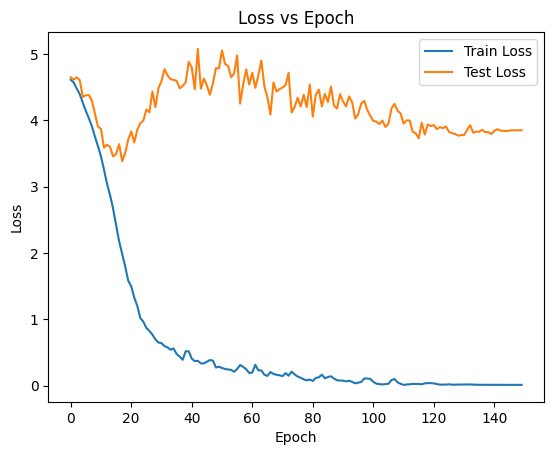

In [77]:
# Loss Visualization over Epochs
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')
plt.show()

Model Evaluation and Predction

In [80]:
test_loss, test_accuracy = evaluate(model, test_dataloader, in_channels, len(test_dataset), 32, criterion)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 3.850077247619629
Test Accuracy: 0.3795620437956204


In [81]:
train_loss, train_accuracy = evaluate(model, train_dataloader, in_channels, len(train_dataset), 32, criterion)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")

Train Loss: 0.004562438817694783
Train Accuracy: 0.9997486173956762


Saving the Model

In [84]:
import os

# Create the directory if it doesn't exist
save_directory = '/content/drive/MyDrive/Sign-Language-Translator/saved_models/'
os.makedirs(save_directory, exist_ok=True)

# Save the model states with .pth extension
model_path = os.path.join(save_directory, 'sentence_level_model_states_v3.pth')
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/Sign-Language-Translator/saved_models/sentence_level_model_states_v3.pth


Hyperparameter Tuning using Optuna

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 29.6 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
# objective function
def objective(trail):
  # hyperparameter vaue from search space
  frame_hidden_layers = trail.suggest_int('frame_hidden_layers', 0, 3) # Reduced max layers
  frame_fc_dropout = trail.suggest_float('frame_fc_dropout', 0.0, 0.5, step=0.05)
  frame_dim = trail.suggest_int('frame_dim', 32, 512, step=32) # Frame encoder output dim

  num_temporal_layers = trail.suggest_int('num_temporal_layers', 1, 3) # Reduced max layers
  temporal_size = trail.suggest_int('temporal_size', 64, 1024, step=64) # Reduced max size
  temporal_dropout = trail.suggest_float('temporal_dropout', 0.0, 0.5, step=0.05)
  # rnn_type = trail.suggest_categorical('rnn_type', ['GRU', 'TRANSFORMER']) # Removed RNN for efficiency
  # bidir = trail.suggest_categorical('bidir', [True, False]) # Reduced options

  class_hidden_layers = trail.suggest_int('class_hidden_layers', 0, 2) # Reduced max layers

  learning_rate = trail.suggest_float('learning_rate', 1e-5, 1e-2, log=True) # Increased max learning rate
  # max_lr = trail.suggest_float('max_lr', 1e-3, 1e-2, log=True)

  weight_decay = trail.suggest_float('weight_decay', 1e-5, 1e-2, log=True) # Reduced min weight decay
  # batch_size = trail.suggest_categorical('batch_size', [32, 64, 128]) # Reduced batch size options
  # optimizer_name = trail.suggest_categorical('optimizer', ['Adam', 'RMSProp']) # Removed SGD for efficiency


  optimizer_name = 'Adam'
  batch_size = 32
  rnn_type = 'GRU'
  epochs = 40 # Reduced epochs for faster trials
  num_nodes = 543 # Use the already defined num_nodes
  in_channels = 3

  frame_proj_neurons, proj_dropout_rates = [], []
  for i in range(frame_hidden_layers):
    frame_proj_neurons.append(trail.suggest_int(f'frame_proj_neurons_{i}', 64, 1024, step=64)) # Reduced max neurons
    proj_dropout_rates.append(trail.suggest_float(f'proj_dropout_rate_{i}', 0.0, 0.5, step=0.05)) # Reduced max dropout

  class_hidden_neurons, class_dropout_rates = [], []
  for i in range(class_hidden_layers):
    class_hidden_neurons.append(trail.suggest_int(f'class_hidden_neurons_{i}', 256, 4096, step=128)) # Reduced max neurons
    class_dropout_rates.append(trail.suggest_float(f'class_dropout_rate_{i}', 0.0, 0.5, step=0.05)) # Reduced max dropout

  # model initialize
  in_frame_size = num_nodes * in_channels
  output_size = num_classes # Use the already defined num_classes

  model = MyModel(in_frame_size, frame_proj_neurons, proj_dropout_rates, frame_fc_dropout, frame_dim,
                 temporal_size, num_temporal_layers, temporal_dropout, output_size,
                 class_hidden_neurons, class_dropout_rates, rnn_type=rnn_type)
  model.to(device)

  # params initialize
  criterion = nn.CrossEntropyLoss()

  # create data loader
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=video_collate_fn)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=video_collate_fn)

  steps_per_epoch = len(train_loader)

  # select optimizer
  if optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'RMSProp':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
      raise ValueError("Unsupported optimizer")

  # select scheduler
  scheduler = OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=steps_per_epoch, epochs=epochs)

  # training loop
  for epoch in range(epochs):
    for x_batch, y_batch in train_loader:
      x_batch, y_batch = x_batch[:, :, :, :in_channels].to(device), y_batch.to(device)
      y_pred = model(x_batch)

      loss = criterion(y_pred, y_batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      scheduler.step() # Step the scheduler after each batch


  # evauation
  model.eval()
  _, accuracy = evaluate(model, test_loader, in_channels, len(test_dataset), batch_size, criterion)

  # return accuracy
  return accuracy

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())

[I 2025-09-20 09:40:42,382] A new study created in memory with name: no-name-d258f001-ac6a-4a40-a053-9b1ce6fb1515


In [ ]:
study.optimize(objective, n_trials=30)

[I 2025-09-20 09:42:06,591] Trial 0 finished with value: 0.02636916835699797 and parameters: {'frame_hidden_layers': 2, 'frame_fc_dropout': 0.0, 'frame_dim': 448, 'num_temporal_layers': 1, 'temporal_size': 640, 'temporal_dropout': 0.4, 'class_hidden_layers': 1, 'weight_decay': 0.0009720158209450704, 'frame_proj_neurons_0': 128, 'proj_dropout_rate_0': 0.15000000000000002, 'frame_proj_neurons_1': 768, 'proj_dropout_rate_1': 0.35000000000000003, 'class_hidden_neurons_0': 2432, 'class_dropout_rate_0': 0.45}. Best is trial 0 with value: 0.02636916835699797.
[I 2025-09-20 09:44:02,649] Trial 1 finished with value: 0.030425963488843813 and parameters: {'frame_hidden_layers': 1, 'frame_fc_dropout': 0.25, 'frame_dim': 128, 'num_temporal_layers': 2, 'temporal_size': 576, 'temporal_dropout': 0.05, 'class_hidden_layers': 0, 'weight_decay': 3.0343316924213954e-05, 'frame_proj_neurons_0': 640, 'proj_dropout_rate_0': 0.45}. Best is trial 1 with value: 0.030425963488843813.
[I 2025-09-20 09:47:58,621]

KeyboardInterrupt: 

In [ ]:
study.best_params

{'frame_hidden_layers': 0,
 'frame_fc_dropout': 0.05,
 'frame_dim': 128,
 'num_temporal_layers': 1,
 'temporal_size': 640,
 'temporal_dropout': 0.30000000000000004,
 'class_hidden_layers': 2,
 'learning_rate': 9.169591911968858e-05,
 'max_lr': 0.0030787527626395753,
 'weight_decay': 9.714202755023787e-05,
 'class_hidden_neurons_0': 640,
 'class_dropout_rate_0': 0.5,
 'class_hidden_neurons_1': 2944,
 'class_dropout_rate_1': 0.0}

In [ ]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_contour

In [ ]:
plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

In [ ]:
plot_parallel_coordinate(study, params=list(study.best_params.keys()))

Load and Predict Model

In [85]:
import time

In [86]:
save_directory = '/content/drive/MyDrive/Sign-Language-Translator/saved_models'
model_path = os.path.join(save_directory, 'sentence_level_model_states_v3.pth')

model = MyModel(num_nodes*in_channels, [448], [0.3], 0.45, 384, 704, 2, 0.15, output_size,
                [], [], rnn_type="GRU")
model.to(device)

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

MyModel(
  (frame_encoder): FrameEncoder(
    (node_proj): Sequential(
      (0): Linear(in_features=201, out_features=448, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (frame_fc): Sequential(
      (0): Linear(in_features=448, out_features=384, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.45, inplace=False)
    )
  )
  (sequence_classifier): SequenceClassifier(
    (rnn): GRU(384, 704, num_layers=2, batch_first=True, dropout=0.15, bidirectional=True)
    (temp_pool): AdaptiveAvgPool2d(output_size=(1, 1408))
    (classifier): Sequential(
      (0): Linear(in_features=1408, out_features=101, bias=True)
    )
  )
)

In [87]:
def predict_gloss(model, x):
  x = x.unsqueeze(0).to(device)

  with torch.no_grad():
    out = model(x)
    out = nn.functional.sigmoid(out)

  val, ypred = torch.max(out, 1)
  return ypred

In [89]:
# measuring time
start = time.time()

ypred = predict_gloss(model, test_dataset[120][0][:, :num_nodes, :in_channels])
print("Predicted Gloss:", label_to_class[ypred.item()])
print("Actual Gloss:", label_to_class[test_dataset[120][1]])

print(f"Time taken: {time.time() - start}")

Predicted Gloss: i somehow got to know about it
Actual Gloss: he came by train
Time taken: 0.005455732345581055
